In [1]:
#importing needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.gaussian_process.kernels import PairwiseKernel
import keras
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

#this data set was downloaded from: https://www.kaggle.com/datasets/buntyshah/auto-insurance-claims-data
#Data Loading

datapath = "insurance_claims.csv"

data = pd.read_csv(datapath)

original_data = data.copy()
import warnings
warnings.filterwarnings('ignore')

data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [ ]:
pip install tensorflow



# Exploring the data

In [2]:
data.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', '_c39'],
      dtype='object')

In [3]:
data.shape

(1000, 40)

In [4]:
#check missing or null or any values
print("Null Values: " + str(data.isnull().any().sum()))

Null Values: 1


<AxesSubplot:xlabel='fraud_reported'>

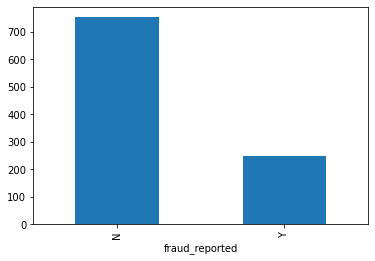

In [5]:
#Fraud Reported Stats
df_count_fraud = data.groupby(['fraud_reported']).count()
df_fraud = df_count_fraud['policy_number']
df_fraud.plot.bar(x='Fraud Reported', y='Count')

<AxesSubplot:xlabel='insured_education_level'>

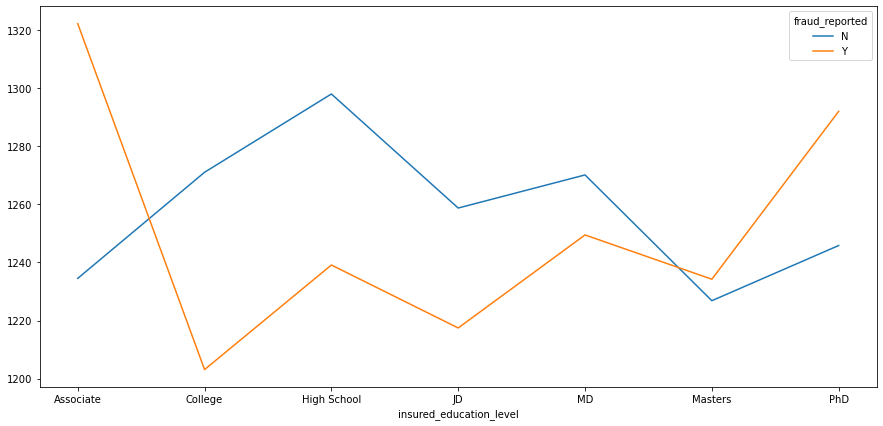

In [6]:
#Annual premium of education level policy_annual_premium
import matplotlib.pyplot as plt

# plot data
fig, ax = plt.subplots(figsize=(15,7))
df_avg_prem = data.groupby(['insured_education_level', 'fraud_reported']).mean()['policy_annual_premium']
df_avg_prem.unstack().plot(ax=ax)

<AxesSubplot:xlabel='insured_occupation'>

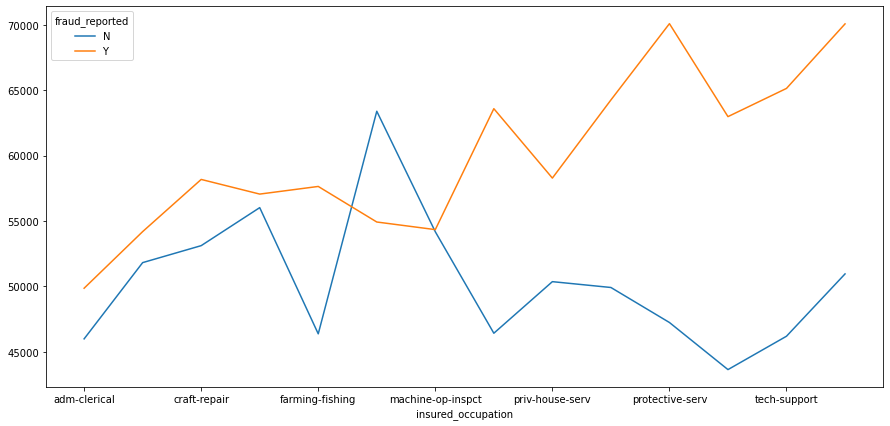

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['insured_occupation', 'fraud_reported']).mean()['total_claim_amount'].unstack().plot(ax=ax)

# Data preprocessing and Tidying

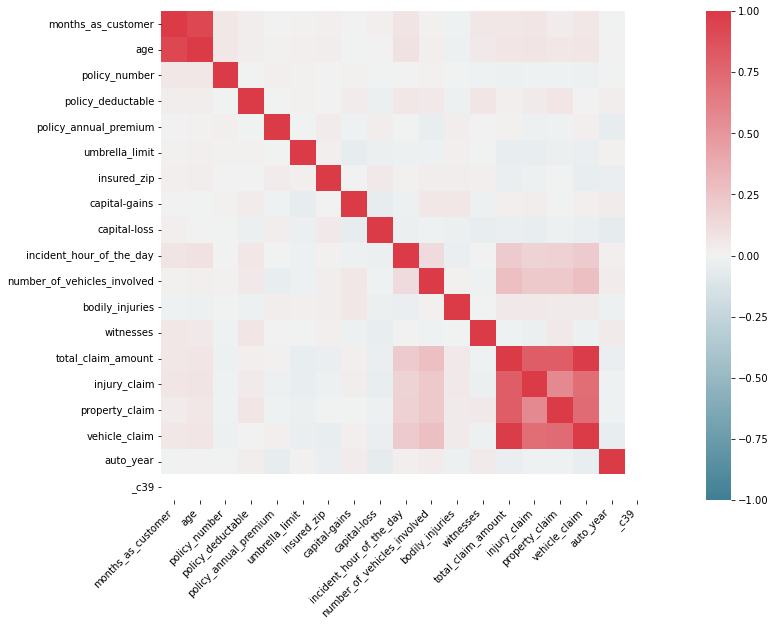

In [8]:
import numpy as np 
import seaborn as sns

plt.figure(figsize=(20, 9))

corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [9]:
#Remove Less Correlated Columns
deleteCols = ["policy_number", "policy_bind_date", "insured_zip", "incident_location", "incident_date", "_c39"]
data = data.drop(deleteCols, axis=1)
data

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,OH,500/1000,1000,1310.80,0,FEMALE,Masters,craft-repair,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,IL,100/300,1000,1436.79,0,FEMALE,PhD,prof-specialty,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,OH,250/500,500,1383.49,3000000,FEMALE,Masters,armed-forces,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,IL,500/1000,2000,1356.92,5000000,MALE,Associate,handlers-cleaners,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


In [10]:
#Handle Categorical Data
data.dtypes

months_as_customer               int64
age                              int64
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                 object
bodily_injuries                  int64
witnesses                        int64
police_report_available  

In [11]:
#One-hot encoding all categorical columns except output column(i.e. fraud_reported)
list_hot_encoded = []
for column in data.columns:
    if(data[column].dtypes==object and column != 'fraud_reported'):
        list_hot_encoded.append(column)
#Drop hot-encoded columns
data = data.drop(list_hot_encoded, axis=1)

#Binary encoder for output column
data['fraud_reported'] = data['fraud_reported'].map( {'Y':1, 'N':0})

data 

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported
0,328,48,1000,1406.91,0,53300,0,5,1,1,2,71610,6510,13020,52080,2004,1
1,228,42,2000,1197.22,5000000,0,0,8,1,0,0,5070,780,780,3510,2007,1
2,134,29,2000,1413.14,5000000,35100,0,7,3,2,3,34650,7700,3850,23100,2007,0
3,256,41,2000,1415.74,6000000,48900,-62400,5,1,1,2,63400,6340,6340,50720,2014,1
4,228,44,1000,1583.91,6000000,66000,-46000,20,1,0,1,6500,1300,650,4550,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,1000,1310.80,0,0,0,20,1,0,1,87200,17440,8720,61040,2006,0
996,285,41,1000,1436.79,0,70900,0,23,1,2,3,108480,18080,18080,72320,2015,0
997,130,34,500,1383.49,3000000,35100,0,4,3,2,3,67500,7500,7500,52500,1996,0
998,458,62,2000,1356.92,5000000,0,0,2,1,0,1,46980,5220,5220,36540,1998,0


# Multi-Layered Perceptron (MLP) (Youssef yasser)

In [12]:
#The Training testing split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

y = data['fraud_reported']
X = data.drop(['fraud_reported'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
from sklearn.neural_network import MLPClassifier
#Newral Network Classifier
clf_MLP = MLPClassifier(max_iter=100)
clf_MLP.fit(X_train, y_train) 
print("MLPClassifier Score :")
clf_MLP.score(X_test,y_test)

MLPClassifier Score :


0.616

In [14]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

mlp_y_predicted = clf_MLP.predict(X_test)
report = classification_report(y_test, mlp_y_predicted)

print(report)

scores = cross_val_score(clf_MLP, X, y, cv=10, scoring='accuracy')
mlp_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % mlp_accuracy)

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       183
           1       0.33      0.42      0.37        67

    accuracy                           0.62       250
   macro avg       0.55      0.55      0.55       250
weighted avg       0.65      0.62      0.63       250

Cross-Validated Accuracy: 0.66


creating an algorithm for hyperparameter tuning to increase the efficacy 

In [15]:
#the space the hyper-parameters will search through
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

In [16]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(clf_MLP, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [17]:
#these are the best parameters for the MLP
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


Creating a new MLP model using the new parameters 

In [18]:
clf_MLP2 = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
                        solver='adam')
clf_MLP2.fit(X_train, y_train) 
print("MLPClassifier Score :")
clf_MLP2.score(X_test,y_test)


MLPClassifier Score :


0.732

In [19]:
mlp_y_predicted2 = clf_MLP2.predict(X_test)
report = classification_report(y_test, mlp_y_predicted2)

print(report)

scores = cross_val_score(clf_MLP2, X, y, cv=10, scoring='accuracy')
mlp_accuracy2 = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % mlp_accuracy2)

              precision    recall  f1-score   support

           0       0.73      1.00      0.85       183
           1       0.00      0.00      0.00        67

    accuracy                           0.73       250
   macro avg       0.37      0.50      0.42       250
weighted avg       0.54      0.73      0.62       250

Cross-Validated Accuracy: 0.75


# Visualizing the difference between MLP before and after hyperparameter tuning

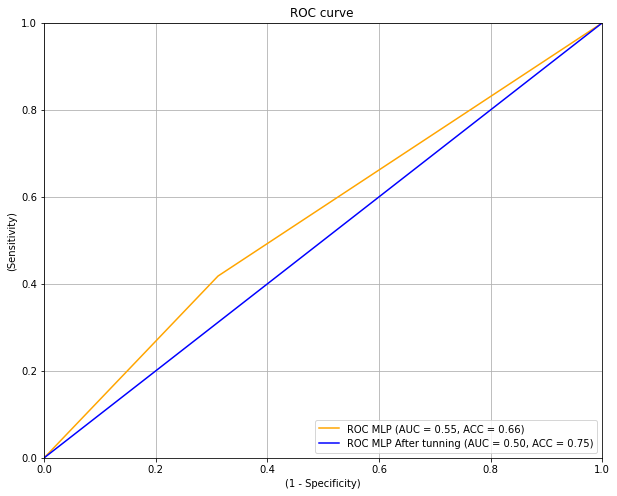

The predictive power of mlp before and after parameter tunning using grid search expressed by ROC curves.


In [20]:
#Comparing the models
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc

fpr8, tpr8, thresholds8 = roc_curve(y_test, mlp_y_predicted)
roc_auc8 = auc(fpr8, tpr8)
fpr9, tpr9, thresholds9 = roc_curve(y_test, mlp_y_predicted2)
roc_auc9 = auc(fpr9, tpr9)

lw = 2
plt.figure(figsize=(10, 8))
plt.plot(fpr8, tpr8, color='orange', label='ROC MLP (AUC = %0.2f, ACC = %0.2f)' % (roc_auc8, mlp_accuracy))
plt.plot(fpr9, tpr9, color='blue', label='ROC MLP After tunning (AUC = %0.2f, ACC = %0.2f)' % (roc_auc9, mlp_accuracy2))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve ')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

print("The predictive power of mlp before and after parameter tunning using grid search expressed by ROC curves.")

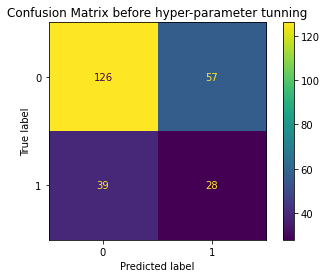

In [21]:
import matplotlib.pyplot as plt
plot_confusion_matrix(clf_MLP, X_test, y_test)  
plt.title('Confusion Matrix before hyper-parameter tunning')
plt.show()

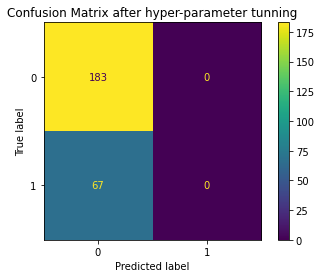

In [22]:
plot_confusion_matrix(clf_MLP2, X_test, y_test)  
plt.title('Confusion Matrix after hyper-parameter tunning')
plt.show()

In [23]:
report = classification_report(y_test, mlp_y_predicted)
print('accuracy report of MLP before hyper-parameter tunning ')
print(report)

scores = cross_val_score(clf_MLP, X, y, cv=10, scoring='accuracy')
mlp_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % mlp_accuracy)

accuracy report of MLP before hyper-parameter tunning 
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       183
           1       0.33      0.42      0.37        67

    accuracy                           0.62       250
   macro avg       0.55      0.55      0.55       250
weighted avg       0.65      0.62      0.63       250

Cross-Validated Accuracy: 0.64


In [24]:
report = classification_report(y_test, mlp_y_predicted2)
print('accuracy report of MLP after hyper-parameter tunning ')
print(report)

scores = cross_val_score(clf_MLP2, X, y, cv=10, scoring='accuracy')
mlp_accuracy = scores.mean()
print('Cross-Validated Accuracy: %0.2f' % mlp_accuracy)

accuracy report of MLP after hyper-parameter tunning 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       183
           1       0.00      0.00      0.00        67

    accuracy                           0.73       250
   macro avg       0.37      0.50      0.42       250
weighted avg       0.54      0.73      0.62       250

Cross-Validated Accuracy: 0.75


# Radial basis function (RBF) (Mahmoud Mohamad)

In [25]:
#KMEANS to find centers

kmeans_model = KMeans(10)   #find 10 centers with kmeans on training samples
kmeans_model.fit(X_train)
centers = kmeans_model.cluster_centers_
X = kmeans_model.predict(kmeans_model.cluster_centers_)
X = keras.utils.to_categorical(X, 10)


y_trainn= kmeans_model.predict(X_train)
y_trainn=keras.utils.to_categorical(y_trainn,10)
y_testt=kmeans_model.predict(X_test)
y_testt=keras.utils.to_categorical(y_testt, 10)


#RBF LAYER

kernel = PairwiseKernel(metric='rbf')   #GPR uses the kernel to define the covariance of the training sample
rbf_model = GaussianProcessRegressor(kernel=kernel).fit(centers, X)

temp1 = rbf_model.predict(X_train)
temp2 = rbf_model.predict(X_test)


#PERCEPTRONS LAYERS
batch_size = 128
epochs = 10

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(10,)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()
nadam=keras.optimizers.Nadam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

#TRAINING THE MODEL
history = model.fit(temp1, y_trainn,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(temp2, y_testt))

#EVALUATE TRAINED MODEL
score = model.evaluate(temp2, y_testt, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
TAC=[]
TAC.append(score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5632      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 10,762
Trainable params: 10,762
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6/6 [==============================] - 1s 35ms/step - loss: 2.3006 - accuracy: 0.7933 - val_loss: 2.2959 - val_accuracy: 0.8120
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 2.2922 - accuracy: 0.7933 - val_loss: 2.2846 - val_accuracy: 0.8120
Epoch 3/10
6/6 [=======================

Trying diffrent parameters for the network structure: Changing the kernel from
- rbf -> polynomial


In [26]:
#KMEANS to find centers

kmeans_model = KMeans(10)   #find 10 centers with kmeans on training samples
kmeans_model.fit(X_train)
centers = kmeans_model.cluster_centers_
X = kmeans_model.predict(kmeans_model.cluster_centers_)
X = keras.utils.to_categorical(X, 10)


y_trainn= kmeans_model.predict(X_train)
y_trainn=keras.utils.to_categorical(y_trainn,10)
y_testt=kmeans_model.predict(X_test)
y_testt=keras.utils.to_categorical(y_testt, 10)


#RBF LAYER

kernel = PairwiseKernel(metric='polynomial')   #GPR uses the kernel to define the covariance of the training sample
rbf_model = GaussianProcessRegressor(kernel=kernel).fit(centers, X)

temp1 = rbf_model.predict(X_train)
temp2 = rbf_model.predict(X_test)


#PERCEPTRONS LAYERS
batch_size = 128
epochs = 10

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(10,)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()
nadam=keras.optimizers.Nadam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

#TRAINING THE MODEL
history = model.fit(temp1, y_trainn,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(temp2, y_testt))

#EVALUATE TRAINED MODEL
score = model.evaluate(temp2, y_testt, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
TAC.append(score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               5632      
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 10,762
Trainable params: 10,762
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6/6 [==============================] - 1s 29ms/step - loss: 2.3298 - accuracy: 0.1667 - val_loss: 2.1932 - val_accuracy: 0.3480
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 2.1617 - accuracy: 0.6133 - val_loss: 2.0564 - val_accuracy: 0.8480
Epoch 3/10
6/6 [=====================

In [27]:
print('accuarcy with rbf kernal: ',TAC[0])
print('accuracy with polynomial kernal: ',TAC[1])

accuarcy with rbf kernal:  0.8119999766349792
accuracy with polynomial kernal:  0.8600000143051147


# Comparing results

the results of best performing RBF and MLP models

In [29]:
print('RBF polynomial kernal: ',TAC[1])
print('Cross-Validated Accuracy: %0.2f' % mlp_accuracy)

RBF polynomial kernal:  0.8600000143051147
Cross-Validated Accuracy: 0.75
